In [1]:
import os
import argparse
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patheffects
import pytorch_lightning as pl
import xml.dom.minidom
import string

from tqdm import tqdm
from torch import nn, optim
from data import HierDataModule
from data import infer_preprocess
from ERDE import ERDE_sample
from model import HierClassifier
from transformers import AutoTokenizer
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from collections import defaultdict, Counter
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import savgol_filter

from model import HierClassifier
from ERDE import ERDE_chunk


/opt/conda/envs/Han/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 注意
version_55前后正态分布sigma不同需要切换 55后为1

In [2]:
clf = HierClassifier.load_from_checkpoint(
    # without time factor"lightning_logs/version_20/checkpoints/epoch=5-step=732.ckpt"
    #with time factor"lightning_logs/version_34/checkpoints/epoch=6-step=854.ckpt"
    #"lightning_logs/version_41/checkpoints/epoch=2-step=366.ckpt"
    # basic Tanh"lightning_logs/version_45/checkpoints/epoch=5-step=732.ckpt"
    #sigmoid"lightning_logs/version_46/checkpoints/epoch=4-step=610.ckpt"
    #relu "lightning_logs/version_47/checkpoints/epoch=4-step=610.ckpt"
    #basic factor"lightning_logs/version_48/checkpoints/epoch=8-step=1098.ckpt"
    #basic factor + norm "lightning_logs/version_51/checkpoints/epoch=4-step=610.ckpt" #second-with bug
    # "lightning_logs/version_53/checkpoints/epoch=4-step=610.ckpt"
    # "lightning_logs/version_55/checkpoints/epoch=3-step=488.ckpt"
    #"lightning_logs/version_57/checkpoints/epoch=4-step=610.ckpt"   #bug fixed
    #"lightning_logs/version_58/checkpoints/epoch=4-step=610.ckpt"   #sota basic schedule
    #"lightning_logs/version_96/checkpoints/epoch=3-step=488.ckpt"    #fusion
    "lightning_logs/version_187/checkpoints/epoch=2-step=366.ckpt"
)
clf.eval()
tokenizer = AutoTokenizer.from_pretrained(clf.model_type)
max_len = clf.hparams.max_len
max_posts = 16
clf.cuda()
None

/opt/conda/envs/Han/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/envs/Han/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
with open("miniLM_L6_embs.pkl", "rb") as f:
    data = pickle.load(f)

train_posts = data["train_posts"]
train_mappings = data["train_mappings"]
train_tags = data["train_labels"]
train_embs = data["train_embs"]
train_timepoints = data["train_timepoints"]
test_posts = data["test_posts"]
test_mappings = data["test_mappings"]
test_tags = data["test_labels"]
test_embs = data["test_embs"]
test_timepoints = data["test_timepoints"]
test_analyze = data["test_analyzes"]

In [4]:
time_dim = 768
assert time_dim%24==0,'time dim should be '
hour_span = time_dim//24
minutes_span = 60//hour_span
half_time_dim = time_dim//2
# Normal distribution
sigma = 1
#sigma = 0.03 # befor version_55
x = np.arange(-time_dim/2, time_dim/2, 1)
y = np.multiply(np.power(np.sqrt(2 * np.pi) * sigma, -1), np.exp(-np.power(x, 2) / 2 * sigma ** 2))
norm = torch.from_numpy(y).to(torch.float32)/16

In [5]:
def trans_timeindexs(timepoints):
    hour_index = timepoints[:,0]
    time_index = hour_index
    return time_index.long()
def norm_emb(timepoints:torch.tensor)->torch.tensor:
    #norm_x = torch.arange(-self.time_dim/2,self.time_dim/2,1)
    #raise Exception(norm_x) #[-xxx,...,xxx-1]
        
    #index = hour * hour_span + minute//minutes_span
    # raise Exception("shape,dtype", timepoints.shape,timepoints.dtype) #('shape', (1131, 2)) int64
    indexs = timepoints[:,0] * hour_span + torch.floor(timepoints[:,0] / minutes_span).to(torch.int)
    indexs = indexs.to(torch.int)
    #raise Exception(indexs.max(),indexs.min())
    embs = torch.zeros(0,time_dim)
    for index in indexs:
        timeline = norm
        if index<half_time_dim:
            cut = half_time_dim-index
            left = norm[:cut]
            right = norm[cut:]
            timeline = torch.cat((right,left),dim=0)
        elif index> half_time_dim:
            cut = index-half_time_dim
            left = norm[:time_dim-cut]
            right = norm[time_dim-cut:]
            timeline = torch.cat((right,left),dim=0)
        embs = torch.cat((embs,timeline.unsqueeze(0)),dim=0)
    return embs

## analyze attention

In [6]:
def infer_texts(texts,textemb_bank,tpindex_bank,analyze):
    tpemb_bank = norm_emb(tpindex_bank)
    batch = infer_preprocess(tokenizer, texts, max_len, tpemb_bank, textemb_bank,trans_timeindexs(tpindex_bank),analyze)
    for k, v in batch.items():
        batch[k] = v.cuda()
    with torch.no_grad():
        logits, attn_score, sc = clf([batch])
    return torch.sigmoid(logits).detach().cpu().item(), sc[-1].squeeze().detach().cpu().numpy(),attn_score

(710, 2) (710, 384)


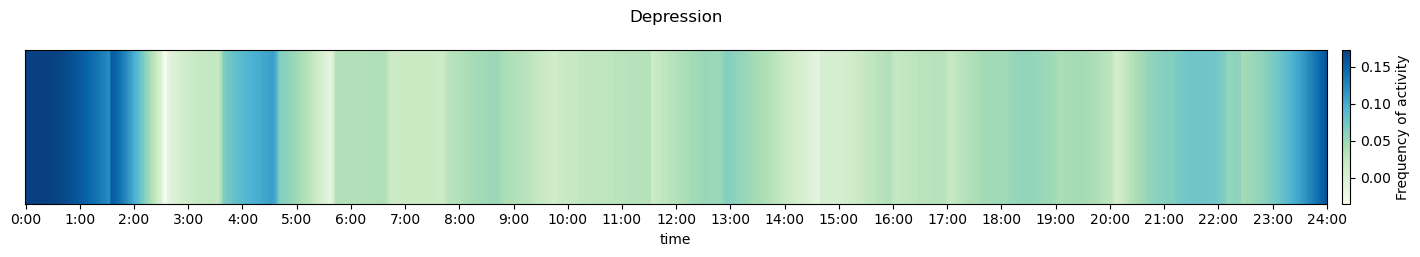

In [7]:
user_id = "355_1"
fname = f"./processed/combined_maxsim16/test/000{user_id}.txt"
fname_a = f"./processed/combined_maxsim16/test_a/000{user_id}.txt"
texts = open(fname).readlines()
analyze = open(fname_a).readlines()
fname_e =  f"./processed/combined_maxsim16/test_t/000{user_id}_emb.npy"
fname_t =  f"./processed/combined_maxsim16/test_t/000{user_id}.npy"
embs =  np.load(fname_e)
timepoints = np.load(fname_t)
print(timepoints.shape,embs.shape)
prob, sc,att = infer_texts(texts,torch.from_numpy(embs),torch.from_numpy(timepoints),analyze)
plt.figure(figsize=(20, 2))  # 宽度 > 高度


smoothed_sc = savgol_filter(sc, 100,2).reshape(1,-1)*100
# 绘制热力图
heatmap = plt.imshow(smoothed_sc,
                    cmap="GnBu",  # 颜色方案
                    aspect="auto",   # 自动调整宽高比
                    interpolation="nearest")

# 自定义坐标轴
plt.gca().xaxis.set_ticks_position("bottom")  # 仅显示x轴
plt.xticks([x*32 for x in range(25)],[str(x)+":00" for x in range(25)])          # 设置x轴刻度间隔
plt.xlabel("time")         # x轴标签
plt.gca().axes.yaxis.set_visible(False)      # 隐藏y轴

# 添加颜色条
cbar = plt.colorbar(heatmap, pad=0.01)
cbar.set_label("Frequency of activity")  # 颜色条标签

# 添加标题
plt.title("Depression", pad=20)
plt.savefig(f"figure/{user_id}.png")
plt.show()

(801, 2) (801, 384)


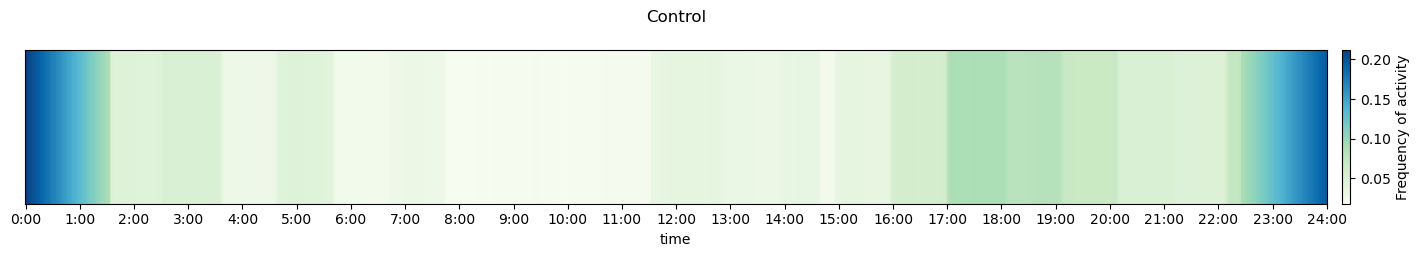

In [8]:
user_id = "007_0"
fname = f"./processed/combined_maxsim16/test/000{user_id}.txt"
fname_a = f"./processed/combined_maxsim16/test_a/000{user_id}.txt"
texts = open(fname).readlines()
analyze = open(fname_a).readlines()
fname_e =  f"./processed/combined_maxsim16/test_t/000{user_id}_emb.npy"
fname_t =  f"./processed/combined_maxsim16/test_t/000{user_id}.npy"
embs =  np.load(fname_e)
timepoints = np.load(fname_t)
print(timepoints.shape,embs.shape)
prob, sc,att = infer_texts(texts,torch.from_numpy(embs),torch.from_numpy(timepoints),analyze)
plt.figure(figsize=(20, 2))  # 宽度 > 高度


smoothed_sc = savgol_filter(sc, 100,1).reshape(1,-1)*100
# 绘制热力图
heatmap = plt.imshow(smoothed_sc,
                    cmap="GnBu",  # 颜色方案
                    aspect="auto",   # 自动调整宽高比
                    interpolation="nearest")

# 自定义坐标轴
plt.gca().xaxis.set_ticks_position("bottom")  # 仅显示x轴
plt.xticks([x*32 for x in range(25)],[str(x)+":00" for x in range(25)])          # 设置x轴刻度间隔
plt.xlabel("time")         # x轴标签
plt.gca().axes.yaxis.set_visible(False)      # 隐藏y轴

# 添加颜色条
cbar = plt.colorbar(heatmap, pad=0.01)
cbar.set_label("Frequency of activity")  # 颜色条标签

# 添加标题
plt.title("Control", pad=20)
plt.savefig(f"figure/{user_id}.png")
plt.show()

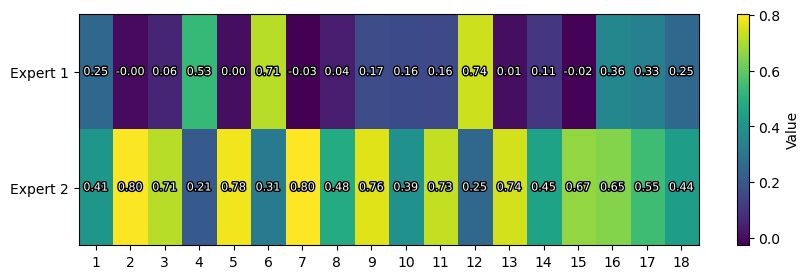

In [24]:
user_id = "355_1"
fname = f"./processed/combined_maxsim16/test/000{user_id}.txt"
fname_a = f"./processed/combined_maxsim16/test_a/000{user_id}.txt"
texts = open(fname).readlines()
analyze = open(fname_a).readlines()
fname_e =  f"./processed/combined_maxsim16/test_t/000{user_id}_emb.npy"
fname_t =  f"./processed/combined_maxsim16/test_t/000{user_id}.npy"
embs =  np.load(fname_e)
timepoints = np.load(fname_t)
#print(timepoints.shape,embs.shape)
prob, sc,att = infer_texts(texts,torch.from_numpy(embs),torch.from_numpy(timepoints),analyze)
g1 = torch.squeeze(att[0][0])
g2 = torch.squeeze(att[0][1])
g1 = g1.cpu().numpy()
g2 = g2.cpu().numpy()
data = np.vstack([g1, g2])
plt.figure(figsize=(10, 3))
im = plt.imshow(data, cmap='viridis', aspect="auto")  # 改用viridis等高对比度配色
plt.colorbar(im, label="Value")
plt.yticks([0, 1], ["Expert 1", "Expert 2"])
plt.xticks(range(18), range(1, 19))
#plt.title("Depression sample contribution")

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        # 添加文本描边效果
        plt.text(j, i, f"{data[i, j]:.2f}", ha="center", va="center",
                 color='white', fontsize=8,
                 path_effects=[patheffects.withStroke(
                     linewidth=2, foreground='black')])
plt.savefig(f"figure/contribution{user_id}.png")
plt.show()

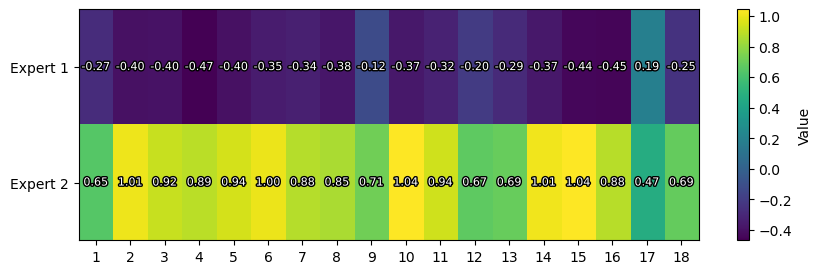

In [25]:
user_id = "007_0"
fname = f"./processed/combined_maxsim16/test/000{user_id}.txt"
fname_a = f"./processed/combined_maxsim16/test_a/000{user_id}.txt"
texts = open(fname).readlines()
analyze = open(fname_a).readlines()
fname_e =  f"./processed/combined_maxsim16/test_t/000{user_id}_emb.npy"
fname_t =  f"./processed/combined_maxsim16/test_t/000{user_id}.npy"
embs =  np.load(fname_e)
timepoints = np.load(fname_t)
#print(timepoints.shape,embs.shape)
prob, sc,att = infer_texts(texts,torch.from_numpy(embs),torch.from_numpy(timepoints),analyze)
g1 = torch.squeeze(att[0][0])
g2 = torch.squeeze(att[0][1])
g1 = g1.cpu().numpy()
g2 = g2.cpu().numpy()
data = np.vstack([g1, g2])
plt.figure(figsize=(10, 3))
im = plt.imshow(data, cmap='viridis', aspect="auto")  # 改用viridis等高对比度配色
plt.colorbar(im, label="Value")
plt.yticks([0, 1], ["Expert 1", "Expert 2"])
plt.xticks(range(18), range(1, 19))
#plt.title("Control sample contribution")

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        # 添加文本描边效果
        plt.text(j, i, f"{data[i, j]:.2f}", ha="center", va="center",
                 color='white', fontsize=8,
                 path_effects=[patheffects.withStroke(
                     linewidth=2, foreground='black')])
plt.savefig(f"figure/contribution{user_id}.png")
plt.show()

3.993032180460432e-07
